# Video Segmentation with SAM 3

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/sam3_video_segmentation.ipynb)

This notebook demonstrates how to use SAM 3 for video segmentation and tracking. SAM 3 provides:

- **Text prompts**: Segment objects using natural language (e.g., "person", "car")
- **Point prompts**: Add clicks to segment and refine objects
- **Object tracking**: Track segmented objects across all video frames
- **Time series support**: Process GeoTIFF time series with georeferencing


## Installation

SAM 3 requires CUDA-capable GPU. Install with:


In [1]:
# %pip install "segment-geospatial[samgeo3]"
# import sys, samgeo

# print("Python executable:", sys.executable)
# print("samgeo file:", getattr(samgeo, "__file__", None))
# print("samgeo version:", getattr(samgeo, "__version__", None))
# print("Has SamGeo3Video?", "SamGeo3Video" in dir(samgeo))

# import sys, importlib
# sys.path.insert(0, "/segment-geospatial")  # make sure your repo wins

# import samgeo
# importlib.reload(samgeo)

# print("samgeo file:", getattr(samgeo, "__file__", None))
# print("Names with 'SamGeo3':", [n for n in dir(samgeo) if "SamGeo3" in n])



## Import Libraries


In [2]:
import os
import sys, importlib
sys.path.insert(0, "/segment-geospatial")  # make sure your repo wins
from samgeo import SamGeo3Video, download_file


To use SamGeo 2, install it as:
	pip install segment-geospatial[samgeo2]
>>> LOADED samgeo FROM /segment-geospatial/samgeo/__init__.py


## Initialize Video Predictor

The `SamGeo3Video` class provides a simplified API for video segmentation. It automatically uses all available GPUs.


In [3]:
sam = SamGeo3Video()

INFO 2025-12-10 14:56:02,013 2719493 sam3_video_predictor.py: 299: using the following GPU IDs: [0, 1]
INFO 2025-12-10 14:56:02,127 2719493 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-12-10 14:56:02,127 2719493 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=2 -- this could take a while ...


Using GPUs: [0, 1]


INFO 2025-12-10 14:56:06,035 2719493 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-12-10 14:56:08,074 2719493 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=2 -- DONE locally
INFO 2025-12-10 14:56:08,074 2719493 sam3_video_predictor.py: 376: spawning 1 worker processes
INFO 2025-12-10 14:56:09,702 2719934 sam3_video_predictor.py: 460: starting worker process rank=1 with world_size=2
INFO 2025-12-10 14:56:09,811 2719934 sam3_video_predictor.py: 317: loading model on rank=1 with world_size=2 -- this could take a while ...
INFO 2025-12-10 14:56:13,669 2719934 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-12-10 14:56:15,514 2719934 sam3_video_predictor.py: 319: loading model on rank=1 with world_size=2 -- DONE locally
INFO 2025-12-10 14:56:15,514 2719934 sam3_video_predictor.py: 469: started worker rank=1 with world_size=2
INFO 2025-12-10 14:56:15,514 2719493 sam3_video_predic

## Load a Video

You can load from different sources:
- MP4 video file
- Directory of JPEG frames
- Directory of GeoTIFFs (for remote sensing time series)


In [4]:
# url = "https://github.com/opengeos/datasets/releases/download/videos/cars.mp4"
# video_path = download_file(url)

In [7]:
# sam.set_video(video_path)
sam.set_video(os.path.abspath("/data/sam3/sources/IMG_4346.MOV"), frame_rate=3, image_output_dir="./output/image", image_ext=".png")
# sam.set_video("./output/image")  # test setting from image directory

Extracting frames to: /segment-geospatial/tests/output/image
Video FPS: 30
Total Frames: 3403
Saving every 10 frame(s)
Finished saving 341 images to /segment-geospatial/tests/output/image


frame loading (image folder) [rank=0]: 100%|██████████| 341/341 [00:30<00:00, 11.27it/s]


Loaded 341 frames. Session started.


In [ ]:
# sam.show_video(video_path)

## Text-Prompted Segmentation

Use natural language to describe objects. SAM 3 finds all instances and tracks them.


In [ ]:
# Segment all car in the video
sam.generate_masks("white plastic exterior", negative_prompt="white wire", frame_idx=0, propagate=True)
# sam.generate_masks("circular connector", frame_idx=630, propagate=False)

Session reset.
Found 1 object(s) matching 'white plastic exterior' on frame 0.


{0: {'out_obj_ids': array([0]),
  'out_probs': array([0.9726027], dtype=float32),
  'out_boxes_xywh': array([[0.28177086, 0.29398146, 0.27526042, 0.44351852]], dtype=float32),
  'out_binary_masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],
        shape=(1, 2160, 3840)),
  'frame_stats': {'num_obj_tracked': np.int64(1), 'num_obj_dropped': 0}}}

## Visualize Results


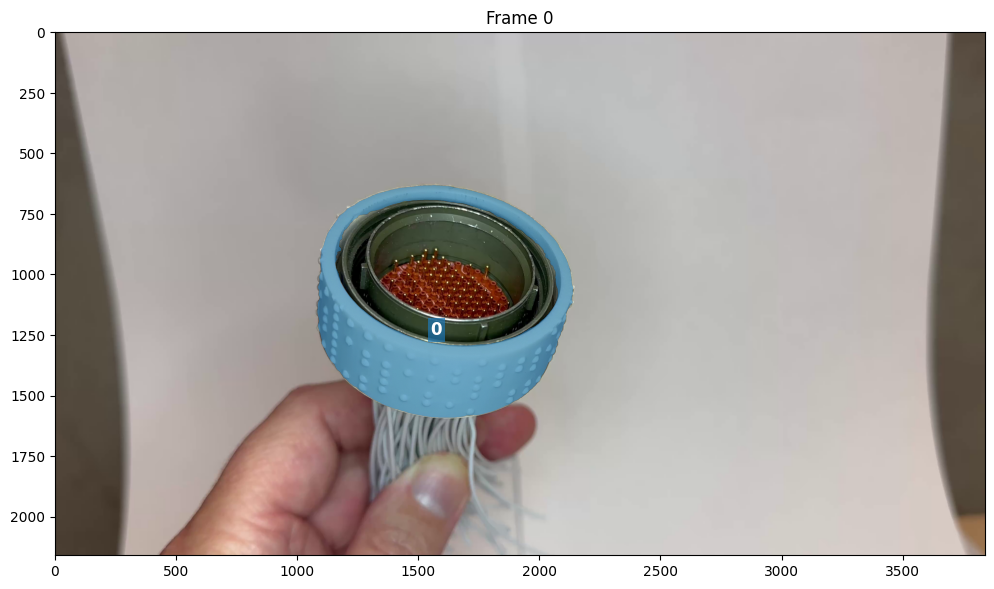

In [12]:
# Show the first frame with masks
sam.show_frame(0, axis="on")

In [ ]:
# Show multiple frames in a grid
sam.show_frames(frame_stride=30, ncols=4)

## Remove Objects

Remove specific objects by ID and re-propagate.


In [ ]:
# Remove object 2 and re-propagate
sam.remove_object(2)
sam.propagate()
sam.show_frame(0)

## Point Prompts

Add objects back or refine segmentation using point prompts.


In [ ]:
# Add back object 2 with a positive point click
sam.add_point_prompts(
    points=[[335, 203]],  # [x, y] coordinates
    labels=[1],  # 1=positive, 0=negative
    obj_id=2,
    frame_idx=0,
)
sam.propagate()
sam.show_frame(0)

## Refine with Multiple Points

Use positive and negative points to refine the mask.


In [ ]:
# Refine to segment only the shirt (not pants)
sam.add_point_prompts(
    points=[[335, 195], [335, 220]],  # detect windshield, not the car
    labels=[1, 0],  # positive, negative
    obj_id=2,
    frame_idx=0,
)
sam.propagate()
sam.show_frames(frame_stride=20, ncols=3)

## Save Results

Save masks as images or create an output video.


In [ ]:
os.makedirs("output", exist_ok=True)

# Save mask images
sam.save_masks("output/mask",binary=True,prefix="")

In [ ]:
# Save video with blended masks
sam.save_video("output/segmented.mp4", fps=25)

## Close Session

Close the session to free GPU resources.


In [ ]:
sam.close()

To completely shutdown and free all resources:

In [ ]:
sam.shutdown()